In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai.callback import *
from fastai.imports import *
from fastai.callbacks.tracker import SaveModelCallback

In [13]:
path = Path('./quora')
bs = 128

## Prepare Data

In [4]:
train_df = pd.read_csv(path/'train.csv', usecols=['question_text'])
test_df = pd.read_csv(path/'test.csv', usecols=['question_text'])

In [5]:
df_all = pd.concat([train_df, test_df], ignore_index=True)
df_all = df_all.sample(frac=1).reset_index(drop=True)

In [7]:
data_lm = (TextList.from_df(df_all, path, cols='question_text')
                .random_split_by_pct(0.1)
                .label_for_lm()           
                .databunch(path=path, bs=bs))


In [8]:
data_lm.show_batch()

idx,text
0,"i build a xxmaj jenkins like live log viewer web application using xxmaj java / javascript ? xxbos xxmaj what parameters do institutes / investors consider before setting up a tech incubator ? xxbos xxmaj what does the initials xxup mash stand for ? xxbos xxmaj why some xxmaj indians are still under rating xxup isro and praising xxup nasa , inspite of xxup isro 's golden acheivements ? xxbos"
1,"ship , will your cargo capacity become larger or smaller ? xxbos xxmaj why do some boys think it 's okay to rape a girl ? xxbos xxmaj what was the relation between xxmaj jesus and the ancient xxmaj scythians ? xxbos xxmaj which version of xxmaj howl 's xxmaj moving xxmaj castle do you like more : novel or movie ? xxbos xxmaj is there a xxunk equivalent from"
2,"xxbos xxmaj do the xxmaj indian police find the xxmaj nigerian drug peddlers so sexy that they do n’t want to hurt or arrest them , while they are destroying young xxmaj indian lives and families , scared chickens ? xxbos xxmaj at what point can you say that somebody has high standards ? xxbos xxmaj what types of food do most cruises include ? xxbos xxmaj will xxmaj missing"
3,"of xxmaj kellin xxmaj quinn xxmaj xxunk 's major accomplishments as a singer ? xxbos i said it was wrong for xxmaj cardi b to have sex on xxmaj instagram live , considering the influence she has . a feminist told me i was slut shaming her . xxmaj who was right ? xxbos xxmaj what are some common criticisms of stoicism ? xxbos xxmaj how can i let go"
4,life is a xxmaj russian troll or bot ? xxmaj do republicans and libertarians not exist in real life without being paid ? xxbos xxmaj why are there a lot of blatant edgy special snowflakes commenting here in xxmaj quora just to fish for upvotes ? xxbos xxmaj what should i know before ordering a custom gaming xxup pc ? xxmaj what do all the parts do and how important


In [9]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '?',
 'the']

In [10]:
data_lm.save('data_lm.pkl')

## Language model

In [4]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [6]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


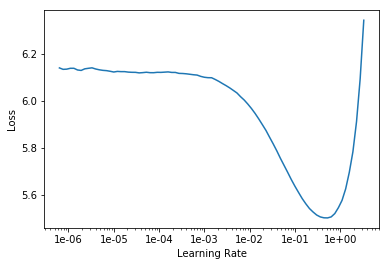

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.903720,3.740231,0.366068,17:42


In [16]:
learn.save('fit_head')

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [17]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1513736 items)
x: LMTextList
xxbos xxmaj should we give rice raw banana and green gram for xxunk ?,xxbos xxmaj would men even get married if the woman did n't have that expectation for them ?,xxbos xxmaj if i sleep for only xxunk a day for a year , what exactly will happen to my body ?,xxbos xxmaj do xxmaj xxunk prefer virgin girls as a wife ?,xxbos xxmaj how can i build a xxmaj jenkins like live log viewer web application using xxmaj java / javascript ?
y: LMLabelList
,,,,
Path: quora;

Valid: LabelList (168192 items)
x: LMTextList
xxbos xxmaj does xxmaj balaji xxmaj vishwanathan write xxmaj quora answers at work ? xxmaj does n't he fall into trouble for doing so ?,xxbos xxmaj what are the characteristics of the different types of stingrays ?,xxbos xxmaj if you could remake any move yourself , which one would you pick ? xxmaj why ?,xxbos xxmaj what factors influence over the weather in xxmaj st. xxmaj augustine , xxmaj florida d

In [18]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


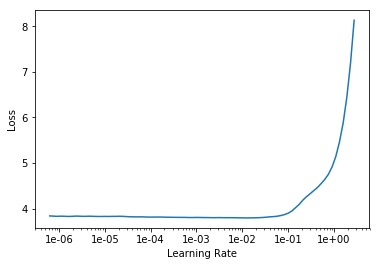

In [ ]:
learn.recorder.plot()

In [13]:
learn.callback_fns.append(partial(
    SaveModelCallback, every='improvement', name='best_fine_tuned' ))

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [7]:
learn.load('best_fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1513736 items)
x: LMTextList
xxbos xxmaj should we give rice raw banana and green gram for xxunk ?,xxbos xxmaj would men even get married if the woman did n't have that expectation for them ?,xxbos xxmaj if i sleep for only xxunk a day for a year , what exactly will happen to my body ?,xxbos xxmaj do xxmaj xxunk prefer virgin girls as a wife ?,xxbos xxmaj how can i build a xxmaj jenkins like live log viewer web application using xxmaj java / javascript ?
y: LMLabelList
,,,,
Path: quora;

Valid: LabelList (168192 items)
x: LMTextList
xxbos xxmaj does xxmaj balaji xxmaj vishwanathan write xxmaj quora answers at work ? xxmaj does n't he fall into trouble for doing so ?,xxbos xxmaj what are the characteristics of the different types of stingrays ?,xxbos xxmaj if you could remake any move yourself , which one would you pick ? xxmaj why ?,xxbos xxmaj what factors influence over the weather in xxmaj st. xxmaj augustine , xxmaj florida d

In [8]:
learn.save_encoder('fine_tuned_enc')

test language model

In [9]:
TEXT = "What is"
N_WORDS = 80
N_SENTENCES = 1

In [10]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

What is the best way to travel from Delhi to Noida by train ? xxbos What is the Roman Catholic Church 's view on the idea of God ? xxbos How did the Founding Fathers react to the Presidency ? xxbos What is the best way to secure English in Hindi ? xxbos How much did it cost to build a Pokémon Island ? xxbos


## Classifier

In [7]:
data_clas = TextClasDataBunch.from_csv(path, 'train.csv', vocab=data_lm.vocab,
                                       text_cols='question_text', label_cols='target',
                                       valid_pct=.2, test='test.csv')


data_clas.save('data_clas.pkl')

In [4]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [5]:
data_clas.show_batch()

text,target
xxbos xxmaj what is [ math ] \ frac { \ xxunk } } \ tan ( \ tan ( { \ boxed { \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk { \ xxunk } } _ { \ xxunk 's xxmaj law of xxmaj theoretical xxmaj probability .,1
xxbos xxmaj given the probabilities [ xxunk < j [ / math ] which describe how probable the elements [ xxunk [ / math ] and [ xxunk [ / math ] are in the same cluster and by knowing the xxunk number of clusters [ xxunk [ / math ] : xxmaj is it somehow possible to get the most probable clustering from this information ?,0
"xxbos xxmaj how would you implement this code to obtain maximum performance for 1 ) xxunk xxup cpu ( without xxup xxunk units ) , with xxup xxunk units 2 ) micro - controller xxmaj for ( int xxup xxunk ; xxup xxunk ; xxup i++ ) { c [ i ] = a [ i ] + b [ i ] ; } ?",0
xxbos xxmaj why ca nt the world love ? xxmaj do we have to show power ? xxmaj rotten xxmaj putin / trump the dump / xxmaj kim ill skunk ? xxmaj flexing their xxunk a world . time for change . we the people must change this world of hatred and reintroduce love . third world war will destroy us all .,1
"xxbos xxmaj at the banquet , xxmaj xi xxmaj jinping was treated xxmaj kim jong xxup un with a xxmaj xxunk liquor valued at xxunk million yuan ( xxup usd 200,000 ) , comparing with family of xxmaj yang xxmaj xxunk with members of 8 had totally annual income of xxup usd 1,300 , what do you think xxmaj chinese communist now ?",0


We can then create a model to classify those reviews and load the encoder we saved before.

In [5]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


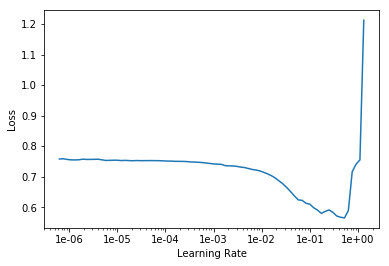

In [8]:
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.143353,0.115862,0.953217,04:06


In [10]:
learn.save('first')

In [11]:
learn.load('first');

In [12]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.121409,0.104723,0.957493,04:44


In [13]:
learn.save('second')

In [14]:
learn.load('second');

In [15]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.104336,0.099980,0.960149,07:35


In [16]:
learn.save('third')

In [6]:
learn.load('third');

In [18]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.095871,0.099333,0.960716,09:55
1,0.097114,0.098880,0.961256,09:56


In [19]:
learn.save('fourth')

## Prediction

In [7]:
preds = learn.get_preds(DatasetType.Valid)
proba = to_np(preds[0][:,1])
ytrue = to_np(preds[1])

In [8]:
from sklearn.metrics import roc_curve, precision_recall_curve
def threshold_search(y_true, y_proba, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.001) 
    F = 2 / (1/precision + 1/recall)
    best_score = np.max(F)
    best_th = thresholds[np.argmax(F)]
    if plot:
        plt.plot(thresholds, F, '-b')
        plt.plot([best_th], [best_score], '*r')
        plt.show()
    search_result = {'threshold': best_th , 'f1': best_score}
    return search_result 

/home/andreas/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


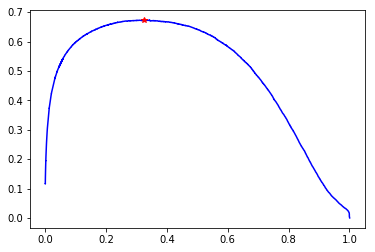

{'threshold': 0.32349973917007446, 'f1': 0.6724242162535624}

In [9]:
thr = threshold_search(ytrue, proba, plot=True); thr

In [10]:
preds = learn.get_preds(DatasetType.Test)
proba = to_np(preds[0][:,1])
predsC = (proba > thr['threshold']).astype(int)

In [15]:
sub = pd.read_csv(path/'sample_submission.csv')
sub.prediction = predsC
sub.to_csv(path/"submission.csv", index=False)

OSError: Initializing from file failed

In [ ]:
sub.head()